In [293]:
%load_ext matrepr

The matrepr extension is already loaded. To reload it, use:
  %reload_ext matrepr


In [294]:
import numpy as np
import matrepr
import pickle as pkl
import json
from pathlib import Path
import re
from evaluation import MetricScore

In [295]:
list(Path("/").glob("{var|home}"))

[]

In [296]:
sorted([1, 2, 0])

[0, 1, 2]

In [298]:
def gather_numbers_one(path="/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/", 
                   experiments=["*extradev*", "*foursquares2*", "*openair*", "*threeballs*", "*threecoloredballs*", "*threeorange*", "*threesimplefruits*"]):
    root = Path(path)
    colnames = None
    alldata = []
    for experimentglob in experiments:
        cand_exppaths = []
        for exppath in root.glob(experimentglob):
            cand_exppaths.append(exppath)
        exppath = sorted(cand_exppaths, reverse=True)[0]
        with open(exppath / "evaluation_results_raw.json") as f:
            evalres = json.load(f)
        _colnames = evalres["colnames"]
        if colnames is None:
            colnames = _colnames
        assert tuple(_colnames) == tuple(colnames)
        evaldata = evalres["data"]
        alldata.append(evaldata)
        print(exppath, len(evaldata))
    return alldata, colnames


def process_numbers_one(data, colnames):
    data = [batchdata for datasetdata in data for batchdata in datasetdata]
    data = np.array(data)     # (num_batches, num_seeds, num_metrics)
    means_per_seed = data.mean(0).T
    means_over_seeds, stds_over_seeds = means_per_seed.mean(1), means_per_seed.std(1)
    
    higher_is_better = np.array([True if MetricScore.from_string(colname).higher_is_better else False for colname in colnames])
    max_over_seeds = data.max(1).mean(0)
    min_over_seeds = data.min(1).mean(0)
    best_over_seeds = np.where(higher_is_better, max_over_seeds, min_over_seeds)

    means_over_seeds_dict = dict(zip(colnames, list(means_over_seeds)))
    stds_over_seeds_dict = dict(zip(colnames, list(stds_over_seeds)))
    best_over_seeds_dict = dict(zip(colnames, list(best_over_seeds)))
    datasize = {
        "numbatches": data.shape[0],
        "numseeds": data.shape[1]
    }
    return {
        "means": means_over_seeds_dict,
        "stds": stds_over_seeds_dict,
        "best": best_over_seeds_dict,
        "datastats": datasize,
        "colnames": colnames
    }


class DataRowEntry:
    def __init__(self, mean, std, best):
        self.mean, self.std, self.best = mean, std, best
        
    def to_latex(self, showstd=False, showbest=False, precision=2):
        ret = f"${self.mean:.{precision}f}$"
        if showstd:
            # ret += f" {{\\tiny $\pm {self.std:.{precision}f}$}}"
            ret += f" $^{{\\tiny \pm {self.std:.{precision}f}}}$"
        if showbest:
            # ret += f"$^{{({self.best:.{precision}f})}}$"
            ret += f"{{\scriptsize (${self.best:.{precision}f}$) }}"
        return ret


class DataRow:
    def __init__(self, datadict, rowname=None, selectcols=None):
        super().__init__()
        self.datadict = datadict
        self.rowname = rowname
        self.selectcols = [str(selectcol) for selectcol in selectcols] if selectcols is not None else None
        self.process_data()
        
    def process_data(self):
        if self.selectcols is None:
            selectedcols = []
            for metric in self.datadict["means"].keys():
                selectedcols.append(str(metric))
        else:
            selectedcols = [selectedcol for selectedcol in self.selectcols if selectedcol in self.datadict["means"]]
        
        entries = []
        for selectedcol in selectedcols:
            entries.append(DataRowEntry(self.datadict["means"][selectedcol], self.datadict["stds"][selectedcol], self.datadict["best"][selectedcol]))
        
        self.entries = entries
        self.selectedcols = selectedcols
        
    def to_latex(self, showstd=False, showbest=False, lastrow=False, precision=2):
        ret = " & ".join([entry.to_latex(showstd=showstd, showbest=showbest, precision=precision) for entry in self.entries])
        if self.rowname is not None:
            ret = f"{self.rowname} & " + ret
        if not lastrow:
            ret += " \\\\"
        return ret
    

class StringRow:
    def __init__(self, x):
        self.x = x
        
    def to_latex(self, **kw):
        return self.x


In [299]:
def get_datarows(paths=(("GLIGEN (\\tau=1.0)", "/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0"),
                        ("DD (orig.)", "/USERSPACE/lukovdg1/DenseDiffusion/dd_outputs"),
                        ("ControlNet*", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1"),
                        ("\quad +CAC", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_cac_v5_exp_1"),
                        ("\quad +DD (w=0.5)", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_dd_v5_exp_1/"),
                        ("\quad +eDiff-I (w=0.5)", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_legacy-NewEdiffipp_v5_exp_2/"),
                        ("\quad +CA-Redist (a+m)", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_posattn5a_v5_exp_5/"),
                        ("\quad +CA-Redist (m)", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_posattn5a_v5_exp_2/"),
                        ("\quad +CA-Redist (a)", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_posattn5a_v5_exp_4/"),
                        ("\quad +CA-Redist (none)", "/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_posattn5a_v5_exp_1/"),
                       ),
                 experiments=["*extradev*", "*foursquares2*", "*openair1*", "*threeballs1*", "*threecoloredballs1*", "*threeorange1*", "*threesimplefruits1*"],
                 selectcols=['Metric[brisque,-]', 'Metric[maniqa,+]', 'Metric[laion_aest_score,+]', 'Metric[localclip_logits,+]', 'Metric[localclip_acc,+]'],
                ):
    rows = []
    for path in paths:
        print(path)
        if isinstance(path, tuple):
            k, v = path
            datadict = process_numbers_one(*gather_numbers_one(v, experiments=experiments))
            datarow = DataRow(datadict, rowname=k, selectcols=selectcols)
            rows.append(datarow)
        else:
            rows.append(StringRow(path))
        
    return rows

In [300]:
rows = get_datarows()
print("")
rows = [row.to_latex(showstd=True, showbest=True) for row in rows]
print("\n".join(rows))

('GLIGEN (\\tau=1.0)', '/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0')
/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/extradev_1_out 4
/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/foursquares2_1_out 20
/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/openair1_1_out 20
/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/threeballs1_1_out 20
/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/threecoloredballs1_1_out 20
/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/threeorange1_1_out 20
/USERSPACE/lukovdg1/DenseDiffusion/gligen_outputs/with_bgr/tau=1.0/threesimplefruits1_1_out 20
('DD (orig.)', '/USERSPACE/lukovdg1/DenseDiffusion/dd_outputs')
/USERSPACE/lukovdg1/DenseDiffusion/dd_outputs/extradev_1_out 4
/USERSPACE/lukovdg1/DenseDiffusion/dd_outputs/foursquares2_1_out 20
/USERSPACE/lukovdg1/DenseDiffusion/dd_outputs/openair1_1_out 20
/USERSPACE/lukovdg1/Den

In [275]:
print(DataRowEntry(09.22344, 1.2, 12.34).to_latex(showstd=True, showbest=True))

$9.22$ $^{\tiny \pm 1.20}${\scriptsize ($12.34$) }


In [241]:
datadict = process_numbers_one(*gather_numbers_one("/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/"))

/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/generated_extradev.pkl_1 4
/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/generated_foursquares2.pkl_1 20
/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/generated_openair1.pkl_2 20
/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/generated_threeballs1.pkl_1 20
/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/generated_threecoloredballs1.pkl_1 20
/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/generated_threeorange1.pkl_1 20
/USERSPACE/lukovdg1/controlnet11/checkpoints/v5/checkpoints_coco_global_v5_exp_1/generated_threesimplefruits1.pkl_1 20


In [182]:
datarow = DataRow(datadict, rowname="GLIGEN", selectcols=['Metric[brisque,-]', 'Metric[maniqa,+]', 'Metric[laion_aest_score,+]', 'Metric[localclip_acc,+]', 'Metric[localclip_logits,+]', 'Metric[localclip_probs,+]'])

In [183]:
print(datarow.selectedcols)
print(len(datarow.selectedcols))
print(datarow.to_latex(showstd=True, showbest=True))

['Metric[brisque,-]', 'Metric[maniqa,+]', 'Metric[laion_aest_score,+]', 'Metric[localclip_acc,+]', 'Metric[localclip_logits,+]', 'Metric[localclip_probs,+]']
6
GLIGEN & $30.56$ {\scriptsize $\pm 1.78$}$^{(10.23)}$ & $0.65$ {\scriptsize $\pm 0.00$}$^{(0.70)}$ & $5.51$ {\scriptsize $\pm 0.04$}$^{(6.08)}$ & $0.33$ {\scriptsize $\pm 0.01$}$^{(0.50)}$ & $21.60$ {\scriptsize $\pm 0.17$}$^{(23.19)}$ & $0.32$ {\scriptsize $\pm 0.01$}$^{(0.48)}$ \\


In [10]:
colnames = [chr(i+97) for i in range(15)]
print(colnames)
x = np.random.random((15, 15)) * 100

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o']


In [16]:
print(matrepr.to_latex(x, floatfmt=".2f", max_rows=50, max_cols=50))
matrepr.mdisplay(x, floatfmt=".2f", max_rows=50, max_cols=50, col_labels=colnames)

\left[\begin{array}{ccccccccccccccc}
    63.51 & 13.84 & 19.13 & 59.00 & 58.91 & 34.13 & 60.61 & 94.35 & 2.07 & 1.15 & 35.60 & 93.23 & 54.49 & 20.19 & 81.09 \\
    97.51 & 41.62 & 22.35 & 92.01 & 6.01 & 55.41 & 69.14 & 8.29 & 97.63 & 43.21 & 43.85 & 62.19 & 32.64 & 0.98 & 2.30 \\
    67.63 & 36.20 & 35.87 & 84.12 & 61.74 & 80.33 & 54.80 & 74.76 & 9.03 & 49.34 & 1.69 & 49.75 & 47.43 & 57.22 & 49.16 \\
    43.51 & 80.00 & 74.66 & 89.81 & 36.55 & 16.97 & 32.79 & 87.11 & 52.71 & 83.74 & 35.26 & 91.41 & 3.38 & 30.78 & 24.96 \\
    38.89 & 32.18 & 76.44 & 60.95 & 72.16 & 62.41 & 86.60 & 69.42 & 4.02 & 60.79 & 73.22 & 31.55 & 2.96 & 84.43 & 75.74 \\
    50.73 & 50.91 & 46.55 & 90.98 & 3.75 & 61.69 & 70.71 & 84.40 & 78.28 & 88.59 & 4.28 & 57.70 & 65.06 & 71.12 & 85.96 \\
    73.94 & 42.14 & 17.99 & 88.19 & 87.06 & 41.66 & 63.40 & 29.05 & 76.18 & 3.45 & 70.02 & 27.52 & 38.08 & 86.31 & 78.69 \\
    56.86 & 30.15 & 82.00 & 32.26 & 19.37 & 58.05 & 28.25 & 48.91 & 8.06 & 56.36 & 15.65 & 1.29 & 82.7

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o
0,63.51,13.84,19.13,59.00,58.91,34.13,60.61,94.35,2.07,1.15,35.60,93.23,54.49,20.19,81.09
1,97.51,41.62,22.35,92.01,6.01,55.41,69.14,8.29,97.63,43.21,43.85,62.19,32.64,0.98,2.30
2,67.63,36.20,35.87,84.12,61.74,80.33,54.80,74.76,9.03,49.34,1.69,49.75,47.43,57.22,49.16
3,43.51,80.00,74.66,89.81,36.55,16.97,32.79,87.11,52.71,83.74,35.26,91.41,3.38,30.78,24.96
4,38.89,32.18,76.44,60.95,72.16,62.41,86.60,69.42,4.02,60.79,73.22,31.55,2.96,84.43,75.74
5,50.73,50.91,46.55,90.98,3.75,61.69,70.71,84.40,78.28,88.59,4.28,57.70,65.06,71.12,85.96
6,73.94,42.14,17.99,88.19,87.06,41.66,63.40,29.05,76.18,3.45,70.02,27.52,38.08,86.31,78.69
7,56.86,30.15,82.00,32.26,19.37,58.05,28.25,48.91,8.06,56.36,15.65,1.29,82.73,54.44,53.71
8,48.78,12.05,67.24,39.31,15.17,98.75,2.61,46.23,58.82,21.72,83.03,57.76,55.15,46.94,46.39
9,49.51,58.49,58.22,86.71,53.06,86.00,49.75,67.89,78.06,59.43,94.82,8.94,26.22,24.36,95.55


In [280]:
pkl

<module 'pickle' from '/home/lukovdg1/.conda/envs/control-v11/lib/python3.8/pickle.py'>

In [283]:
d = pkl.load(open("/USERSPACE/lukovdg1/DenseDiffusion/dd_outputs/extradev_1_out/outbatches.pkl", "rb"))

In [284]:
len(d)

4

In [292]:
d[0][0]["image"].size

(512, 512)

In [391]:
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import random
plt.rcParams['figure.figsize'] = (6,2)
from matplotlib.ticker import FormatStrFormatter

In [374]:
qk = torch.randn(12)
c = qk.softmax(-1)

In [385]:
b_frt = torch.tensor([0,0,0,0,0,0,0,0,0,1,1,0])
b_R = torch.tensor([0,0,0,0,0,1,0,1,0,1,1,0])

In [403]:
c_local = (torch.log(b_frt) + qk).softmax(-1)
c_global = (torch.log(1 - b_R) + qk).softmax(-1)
m = (b_R * c).sum()
c_new = m * c_local + (1 - m) * c_global

xs = [i + 1 for i in range(len(c))]

In [404]:
print(m)

tensor(0.5164)


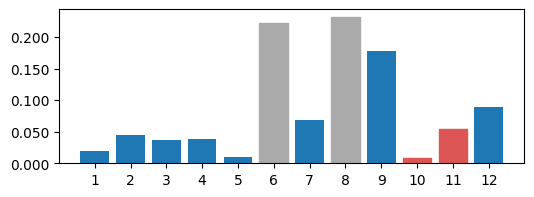

In [430]:
fig, ax = plt.subplots()

bars = ax.bar(xs, c.numpy())
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

bars[5].set_color("#aaaaaa")
bars[7].set_color("#aaaaaa")
bars[9].set_color("#dd5555")
bars[10].set_color("#dd5555")

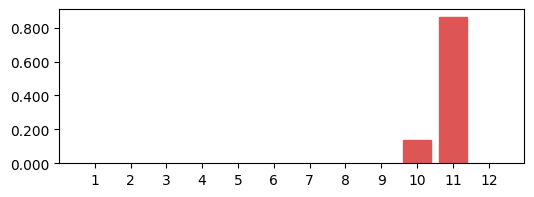

In [431]:
fig, ax = plt.subplots()

bars = ax.bar(xs, c_local.numpy())
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

bars[9].set_color("#dd5555")
bars[10].set_color("#dd5555")

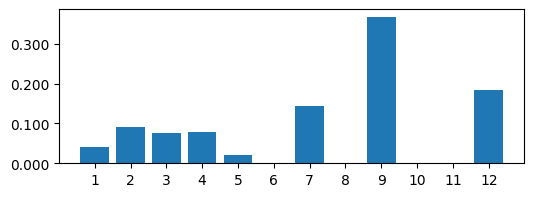

In [432]:
fig, ax = plt.subplots()

ax.bar(xs, c_global.numpy())
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

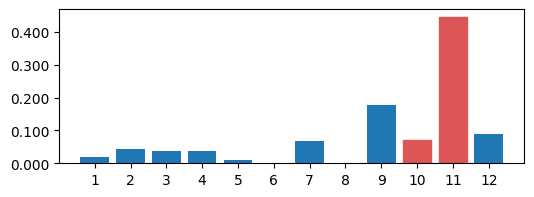

In [433]:
fig, ax = plt.subplots()

bars = ax.bar(xs, c_new.numpy())
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

bars[9].set_color("#dd5555")
bars[10].set_color("#dd5555")

In [434]:
c - c_new

tensor([ 1.8626e-09,  7.4506e-09,  1.1176e-08,  7.4506e-09,  3.7253e-09,
         2.2209e-01,  7.4506e-09,  2.3213e-01,  4.4703e-08, -6.1381e-02,
        -3.9284e-01,  2.2352e-08])

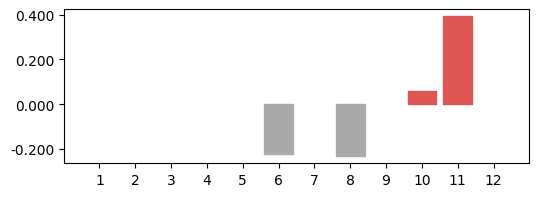

In [435]:
fig, ax = plt.subplots()

bars = ax.bar(xs, (c_new - c).numpy())
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

bars[5].set_color("#aaaaaa")
bars[7].set_color("#aaaaaa")
bars[9].set_color("#dd5555")
bars[10].set_color("#dd5555")

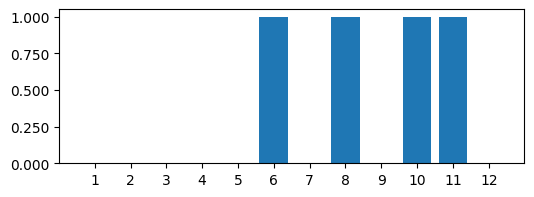

In [437]:
fig, ax = plt.subplots()

bars = ax.bar(xs, b_R.numpy())
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))


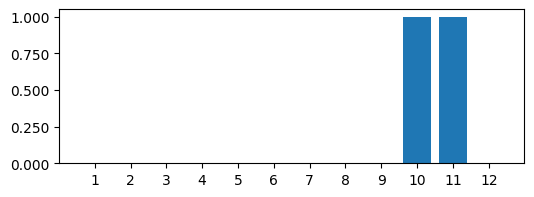

In [438]:
fig, ax = plt.subplots()

bars = ax.bar(xs, b_frt.numpy())
ax.set_xticks(xs)
ax.set_xticklabels(xs)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
